## Airbnb User Booking Data
**Problem Statement:** Using data collected on users, explore ways to predict the location of the country booked. This can help target ads, interfaces or suggestions to make the user experience more personalized.

**Approach:** Given the mix of regression and classification data, models that could handle categorical data seemed to be the best approach as there are several data preprocessing methods that are beneficial to handling this data spread. The two models chosen are Decision Trees (Random Forest, XGBoost, Catboost and ensemble of the three) as well as K-Means clustering. Determining which features impacted the booked country destination was a beneficial approach in predictions.

# Imports and File Reads

In [3]:
import pandas as pd
import numpy as np
from dataprep.eda import create_report
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import resample

from scipy.stats import chi2_contingency, f_oneway
from imblearn.over_sampling import SMOTENC
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Rename filepath prefix for your respective folder hierarchies
filepath_prefix = 'airbnb-recruiting-new-user-bookings/' # dominic
# filepath_prefix = 'dataset\\' # pawan
# filepath_prefix = '' # kim

df_airbnb_users = pd.read_csv(f'{filepath_prefix}train_users_2.csv')
df_sessions = pd.read_csv(f'{filepath_prefix}sessions.csv')
df_countries = pd.read_csv(f'{filepath_prefix}countries.csv')
df_age_bkts = pd.read_csv(f'{filepath_prefix}age_gender_bkts.csv')

# Exploratory Data Analysis

create_report is a quick and easy way to perform exploratory data analysis. It reveals the distribution of categorical variables across different entries and the shape of distribution for continuous variables. This simple but detailed report also provides insights on missing values and some basic correlations.

In [5]:
#create_report(df_airbnb_users)

The report showcases missing data for Age and Date_First_Booking. Similarly, high cardinality of other date-like variables was observed and corrected for later in the notebook. For Age, there is additional anomaly seen in the range of data which is corrected for later in the notebook. Date_First_Booking was removed from analysis as it would not help generalize models for future use of the business.

Create_report provides additional clues on what other EDA to perform, such as assessment of balance of target variables.

## Age Bucket Distribution
Exploring the diversity of ages across the different potential booking countries was an EDA technique used in determining whether demographics of the destination might play into the likelihood a certain user might chose one location over another. This metric also indicates the uneven spread of data quantity for each country, handling of this will be done during the data preprocessing stage. The Airbnb user booking data came from a Kaggle challenge and many of the submissions contained some good EDA, one particularly nice graph is the one below, obtained from the submission https://www.kaggle.com/code/asmaamohy/airbnb-eda

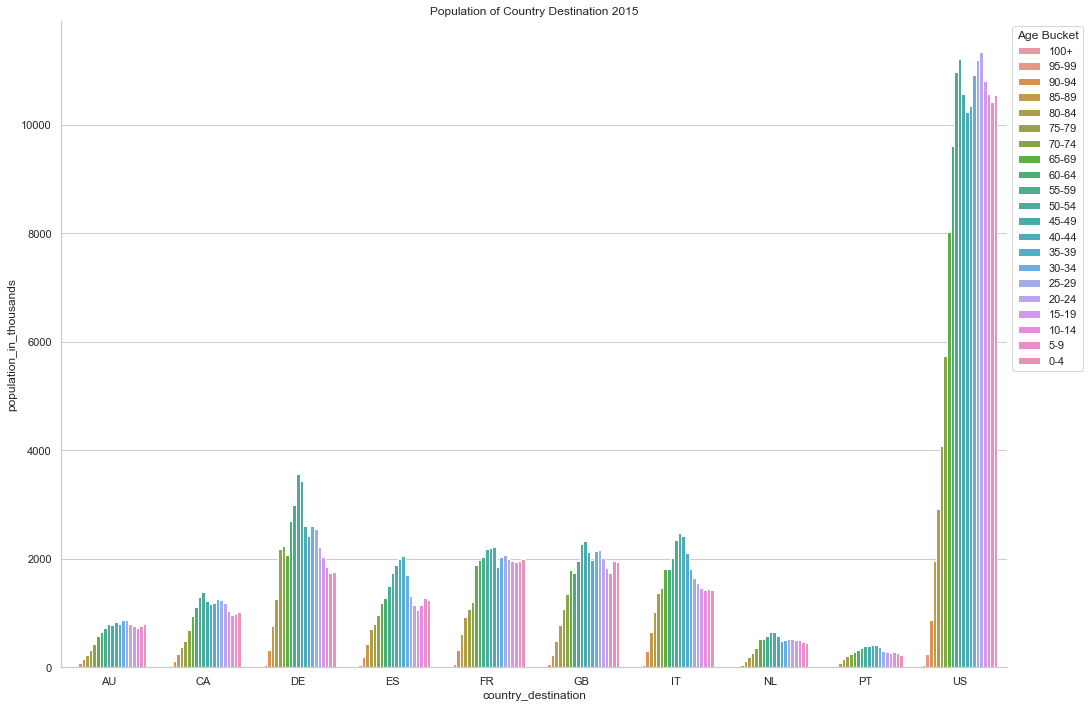

In [117]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
sns.barplot(data=df_age_bkts, x="country_destination", y="population_in_thousands", hue='age_bucket', ci=None, ax=ax)
plt.title('Population of Country Destination 2015')
ax.legend(title='Age Bucket', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend
plt.show()

The graph above shows similar patterns of age distribution for most countries, with some anomalies for Denmark and Italy where there is a spike in the older generation of users. While this data pattern is interesting, the team did not ultimately find it valuable to use the age bracket distribution supplementary dataset for further modeling.

## First Device vs Destination Country
Another explored EDA route was the connection between features and the target feature (Country destination). The code below compares the device type (that the user first used when interacting with the AirBnb site) and the country destination.

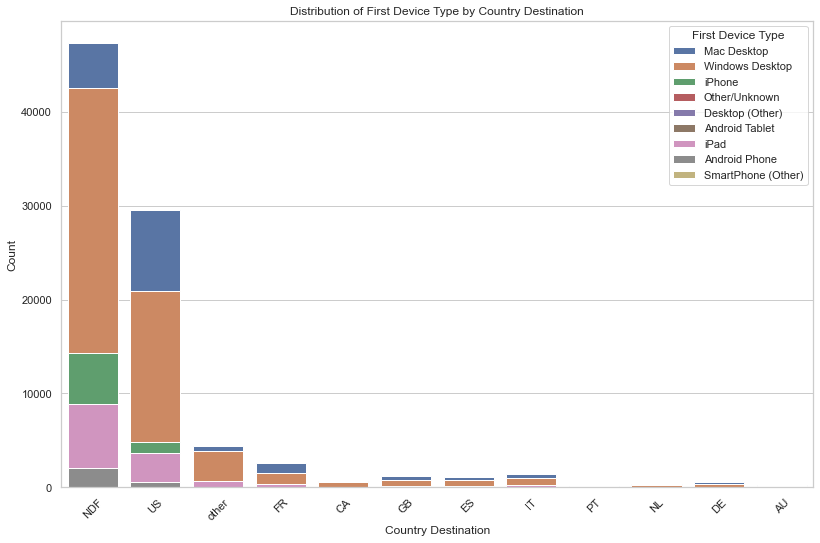

In [7]:
# Assuming df_train_users is your DataFrame
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df_airbnb_users, x='country_destination', hue='first_device_type', dodge=False, ax=ax)

ax.set_title('Distribution of First Device Type by Country Destination')
ax.set_ylabel('Count')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type')

plt.show()

#### Analysis
The graph above shows a few interesting aspects of the data. The most noticable is the spread of the data. The NDS and US country destinations are heavily more represented in the data set than any of the other countries, or even all of the other countries combined. This spread is handled below using sampling. The second takeaway from this graph is type of device used, across all countries, a windows desktop was used so users are most likely looking at bookings from a computer. The distribution is difficult to tell for the other countries, but for NDF (which represents no booking) many of the devices were mobile devices. This could indicate that there is a correlation between device used and no booking being made.

### First Device v Country Destination (Proportion)
The code below is intended to help mitigate the problem outlined above where the distribution of the other countries makes it hard to tell what devices are being used for booking. The code below creates proportions based on device type to tell the percentage of users who booked that country instead of out of overall users. This approach provides more insight into the relationship between this feature and the target feature.

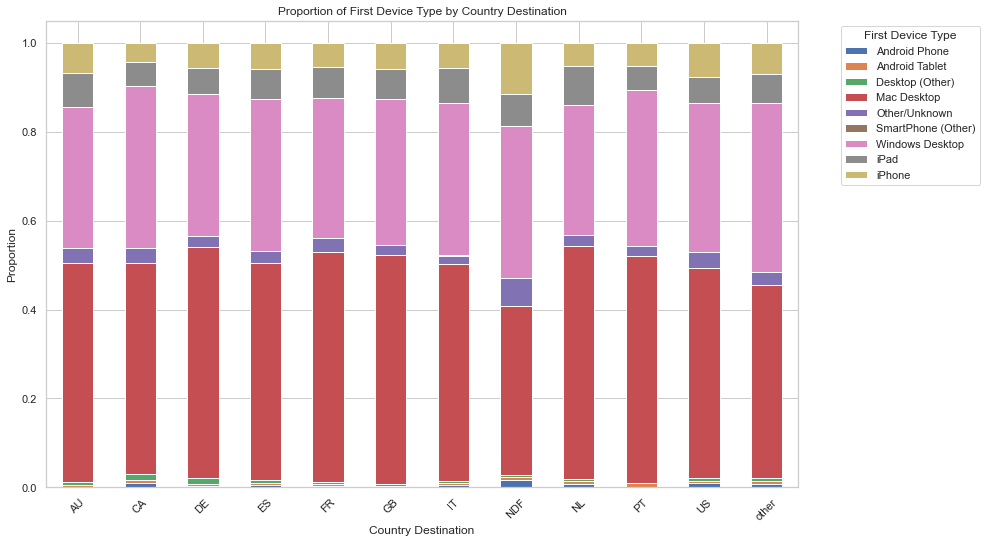

In [8]:
# Assuming df_train_users is your DataFrame
# Step 1: Calculate proportions
proportions = df_airbnb_users.groupby(['country_destination', 'first_device_type']).size().reset_index(name='count')
total_counts = df_airbnb_users['country_destination'].value_counts().reset_index()
total_counts.columns = ['country_destination', 'total_count']

proportions = proportions.merge(total_counts, on='country_destination')
proportions['proportion'] = proportions['count'] / proportions['total_count']

# Step 2: Create a pivot table
pivot_df = proportions.pivot_table(index='country_destination', columns='first_device_type', values='proportion', fill_value=0)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Proportion of First Device Type by Country Destination')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Analysis
Graphing the device type v country destination using proportions creates a clearer picture on the spread of devices to country. It is now more aparant that not just Windows desktops are heavily used, but so are Mac desktops, this confirms users are likely using computers to make bookings. Further looking at the "mobile" type devices, there is less direct correlation of NDF to mobile devices, as it seems the distribution is relatively similar across the countries and NDF.

### Spread of target destinations for different Gender
A similar approach as above can be produced for any combination of categorical variables. In fact, one could iterate overall all through pair combinations in a matrix to observe how different categoricals behave. Below is a stacked bar plot for gender and country of first booking.

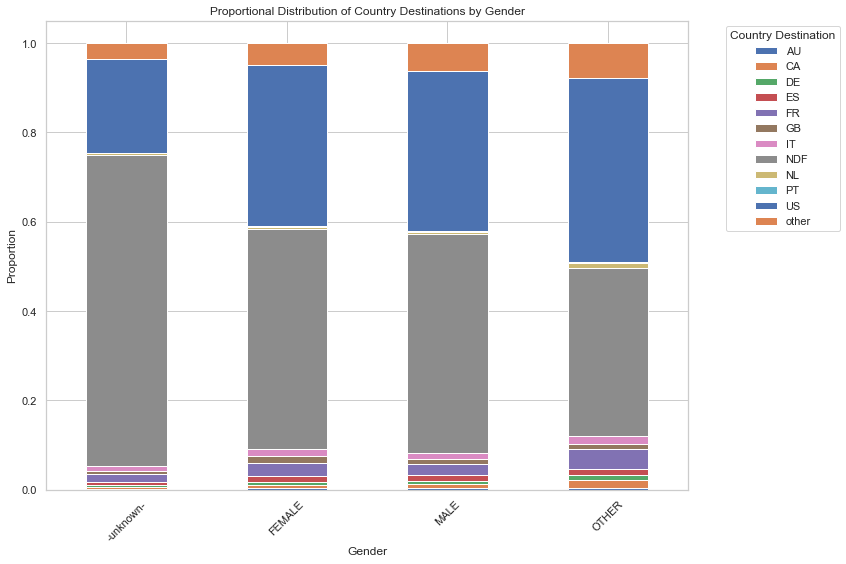

In [118]:
# Calculate the proportions for each gender and country_destination
proportions = df_airbnb_users.groupby('gender')['country_destination'].value_counts(normalize=True).unstack()

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Proportional Distribution of Country Destinations by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.legend(title='Country Destination', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Analyses
The stacked bar plot is a little more interesting that the previous one, with more males booking in Canada, for example. However, this bar does not describe inherent biases in the population. The data set, for example, can have bias in sampling for genders, and this can end up providing an incorrect assumption of the general population

### Age Feature
The age feature seems like it would be a relevant feature, especially after looking at the age distributions across the different countries. In order to understand the data better, it is important to visualize this feature individually to get an understanding of the spread. Create_report showed some interesting anomalies in age, such as there being outliers. A strip plot and a violin plot, especially overlayed, would provide a view into where these values lie on the age axis.

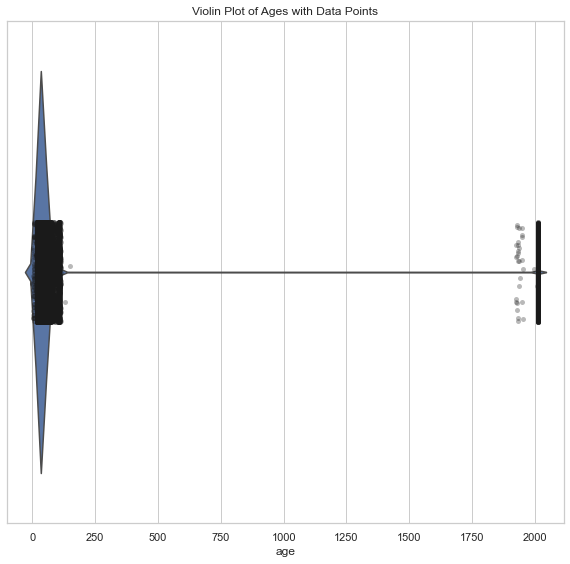

In [10]:
# Plot configurations
plt.figure(figsize=(16, 8))


# Violin Plot with Strip Plot Overlay
plt.subplot(1, 2, 2)
sns.violinplot(x=df_airbnb_users['age'], orient='h', inner=None)  # inner=None removes the default boxplot inside the violin
sns.stripplot(x=df_airbnb_users['age'], orient='h', color='k', alpha=0.3, jitter=True)  # Adding strip plot on top of the violin plot
plt.title('Violin Plot of Ages with Data Points')

# Show the plots
plt.tight_layout()
plt.show()

#### Analysis
Initially looking at the plot of the age feature, there are clearly some impossible outliers. We know humans cannot live to be 2000 years old, so the data points on the far right must be incorrect. Given they are so far from the expected range, they will skew the data significantly. Looking at the values and the timeframe of the dataset, these ages are misentered by putting year of birth instead of age. Another interesting look at the plot shows the relative normal distribution of data, with a spike on the younger side of things. Another important note is users must be 18 to make bookings, so while handling the extreme outliers on the right hand side is important, looking at other "impossible" values on the too young side is important in data integrity.

# Data Cleaning
After initial analysis above, handling the age data as well as dealing with the heavily skewed data for US and NDF country destinations. Data cleaning is important for modeling so the predictions are based on data that has been properly understood and any outliers, NaN values or impossible values have been handled appropriately and the predictions can be more easily understood and interpreted.

In [11]:
df_airbnb_cleaned = df_airbnb_users.copy()

### Age Data Cleaning
The code below helps handle the extreme outliers by computing the average age, which is aobut 36.6 and replacing any extreme outliers with the average as well as replacing NaN values with that average. The dataset dates back to 2010, so all the ages are based on that reference. Users cannot be under 18 to make bookings, so those entries are removed from the dataset. The plot for the new distribution of data is below.

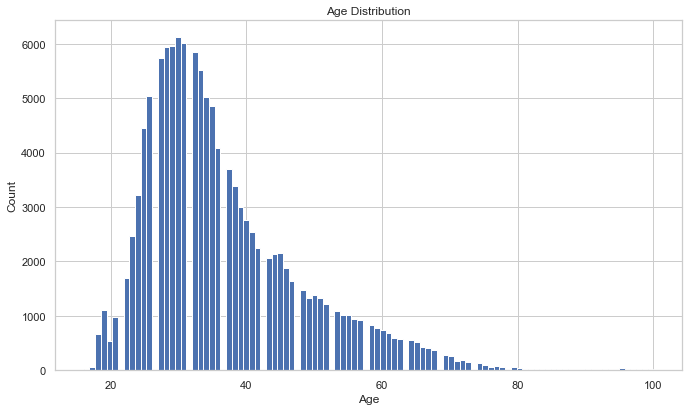

count    123079.000000
mean         36.569236
std          11.703130
min          16.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64


In [12]:
# Adjust the weird ages. Seems like there are some years added to the age

ages = df_airbnb_cleaned['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_airbnb_cleaned['age'] = ages

# Drop Ages < 18, it is AirBnB policy that minimum age of users should be 18

df_airbnb_cleaned = df_airbnb_cleaned[df_airbnb_cleaned['age'] >= 18]

#### Analysis
After applying the code above, the distribution looks normal and there are no outliers or values under 18. This is expected from the box plot above.

### Missing Values
The code below checks for missing values. As is clear from the counts, only data_first_booking and first_affiliate_tracked have missing values. The date_first_booking will be missing if a user does not make a booking, so that data can be dropped. The code below also converts "Unknown" to Nan in the first affiliate tracked feature because Unknown is as relevant as missing data, so we can just drop it.

In [13]:
# Check which features have missing values
df_airbnb_cleaned.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         55781
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     1960
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [14]:
# Convert "Unknown" fields in the first affiliate tracked feature to NaN
df_airbnb_cleaned['first_affiliate_tracked'] = df_airbnb_cleaned['first_affiliate_tracked'].fillna('Unknown')
# Drop Missing Fields
df_airbnb_cleaned = df_airbnb_cleaned.dropna()
# Confirm missing data has been handled
df_airbnb_cleaned.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

### Total Session Time
Often, the more time a user spends on a site, the more likely they are to make a purchase. Using this background the code below uses the session data lookup by user to compute total session time and adds that feature to the data to be used with predictions. This leverages the supplementary user session data in the dataset.

In [15]:
# Calculate the total session time per user ID
total_session_time_per_user = (df_sessions.groupby('user_id')['secs_elapsed'].sum().reset_index())

# Merge the total session time with the df_train using the correct column names
df_airbnb_cleaned = pd.merge(df_airbnb_cleaned, total_session_time_per_user, left_on='id', right_on='user_id', how='left')

# Rename the column to be more descriptive
df_airbnb_cleaned.rename(columns={'secs_elapsed': 'total_session_time'}, inplace=True)

# Drop the redundant 'user_id' column
df_airbnb_cleaned.drop('user_id', axis=1, inplace=True)

# Feature Engineering
The code below removes any missing data from the added total session time feature. The next block of code computes the different between the age of the account and the data of the first booking. This metric is useful in determining the reason a user might sign up for an account. If they are just exploring possible destinations, it would be assumed that the age of the account would be older than first booking. Alternatively, a user might only make an account in order to make a booking, so the age of account would be small.

In [16]:
df_airbnb_cleaned.fillna(value={'total_session_time':0}, inplace=True)

In [17]:
def get_month_diff (date, today):
    date = pd.to_datetime(date)
    return (relativedelta(date, today).years * 12 + relativedelta(date, today).months) * -1

today = datetime.today()
df_airbnb_cleaned['account_age_months'] = df_airbnb_cleaned['date_account_created'].apply(lambda date: get_month_diff(date, today))

df_airbnb_cleaned.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_session_time,account_age_months
0,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,0.0,164
1,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0.0,150
2,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,0.0,165
3,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,0.0,173
4,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,0.0,173


# Feature Importance and Correlation
To understand which features would most add value to our modeling approaches, tests were performed to understand feature importance and correlation. Since the target is a categorical variable, and the features encompass both categorical and numerical variables, the features needed to be separated to perform different tests for each type.

In [18]:
#Extract numerical and categorical columns

categorical_features = df_airbnb_cleaned.select_dtypes(include=['object','category']).columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_indices = [df_airbnb_cleaned.columns.get_loc(col) for col in categorical_features]

### ANOVA Test
The code below determines the correlation between the numerical features and the target feature (country destination). This test helps determine if any features significantly impact the data or which ones can be more discounted. This data preprocessing technique is beneficial in final analysis as well.

In [19]:
# Perform ANOVA test to find association between numerical features and country_destination

destinations = df_airbnb_cleaned['country_destination'].unique()

for numerical_feature in numeric_features:
    arrays = [df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == country][numerical_feature] for country in destinations]
    f_stat, p_value = f_oneway(*arrays)
    print(f'ANOVA F-statistic for feature {numerical_feature}: {f_stat}, p-value: {p_value}')

ANOVA F-statistic for feature timestamp_first_active: 19.743246519866073, p-value: 6.32551045373132e-37
ANOVA F-statistic for feature age: 14.25712298305604, p-value: 1.3390568663021715e-25
ANOVA F-statistic for feature signup_flow: 11.901139535102804, p-value: 8.4065564752738e-21
ANOVA F-statistic for feature total_session_time: 3.617924592971238, p-value: 7.864512741382307e-05
ANOVA F-statistic for feature account_age_months: 25.938078387486925, p-value: 7.2939519798611435e-50


#### Analysis
The outputs from the ANOVA test indicates the significance the features has on the dependent variable. The f-score and p-value help understand if there is a correlation, and if so, the strength. Based on this, it can be noted that the significant features are timestamp_first_active, signup_flow, total_session_time, account_age_months, first_booking_months (all have p-values much lower than 0.05, indicating significant impact on the dependent variable). On the other side, age was the feature that was not significant, the high p-value indicates no significant impact on the country destination.

### Cramers_V Interpretation Scale
The code below computes the Cramers_V scale. This is useful for comparing the importance of categorical features for a categorical target. For reference, this is the general understanding of interpretation of the results.
* 0.00 to 0.10: Negligible association
* 0.10 to 0.20: Weak association
* 0.20 to 0.40: Moderate association
* 0.40 to 0.60: Relatively strong association
* 0.60 to 0.80: Strong association
* 0.80 to 1.00: Very strong association

In [20]:
# Explore how the activity is correlated with all the other variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for categorical_feature in categorical_features:
    cramers_v_result = cramers_v(df_airbnb_cleaned['country_destination'], df_airbnb_cleaned[categorical_feature])
    print(f"Cramers_V output for feature {categorical_feature} = {cramers_v_result}")

C:\Users\HomeBase\AppData\Local\Temp\ipykernel_2680\1938785809.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Cramers_V output for feature id = inf
Cramers_V output for feature date_account_created = 0.04137482383604328
Cramers_V output for feature date_first_booking = 0.05341545178192092
Cramers_V output for feature gender = 0.03204555380505697
Cramers_V output for feature signup_method = 0.011310820262543769
Cramers_V output for feature language = 0.0211593231036234
Cramers_V output for feature affiliate_channel = 0.0296226714914864
Cramers_V output for feature affiliate_provider = 0.02105009204452866
Cramers_V output for feature first_affiliate_tracked = 0.013675158619875349
Cramers_V output for feature signup_app = 0.0301906210352501
Cramers_V output for feature first_device_type = 0.0222122835844345
Cramers_V output for feature first_browser = 0.007795830168501832
Cramers_V output for feature country_destination = 1.0


#### Analysis
The features all have low cramers scores which indicates low relation between country_destination and the categorical features. This insight is valuable for the Decision Tree models as well as k-means as it helps with an understanding of the results. Since we have both regression and categorical data, and the regression data has much stronger relations to the target variable, the emphasis and tuning for the model will be on those variables.

### Data Processing for Models
Features such as "ID", "Date_Account_Created", etc. are not deemed to be useful. Considering this corpus is from a decade ago, the date of first booking will not generalize well so far out. With the adjustment of features, categorical and numeric features indices are re-calculated in order to perform future steps related to sampling.

In [21]:
# Drop ID, Date_Account_Created, Date_First_Booking
df_airbnb_cleaned = df_airbnb_cleaned.drop(columns=['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking'])

#Extract numerical and categorical columns again

categorical_features = df_airbnb_cleaned.select_dtypes(include=['object','category']).columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_indices = [df_airbnb_cleaned.columns.get_loc(col) for col in categorical_features]

### Sampling
As mentioned above, the distribution of the data is heavily weighted for 'US' and 'NDF' in our target feature. This distribution can bias the model towards underfitting. Since there are many features that might impact the country destination, resampling to evenly distribute the features will help create a more accurate model. The code below does this sampling via two means:<br> 
* It first undersamples the majority class, US, and then finds the minority class. 
* Once the undersampling is complete, SMOTE-NC is applied. The choice to use SMOTE-NC over other sampling methods comes from the need to handle both categorical and numeric data.

In [22]:
df_airbnb_cleaned['country_destination'].value_counts()

US       47677
other     7413
FR        3652
IT        1988
GB        1736
ES        1676
CA        1055
DE         834
NL         590
AU         428
PT         156
Name: country_destination, dtype: int64

US       7413
other    7413
CA       7413
FR       7413
IT       7413
ES       7413
GB       7413
NL       7413
DE       7413
AU       7413
PT       7413
Name: country_destination, dtype: int64


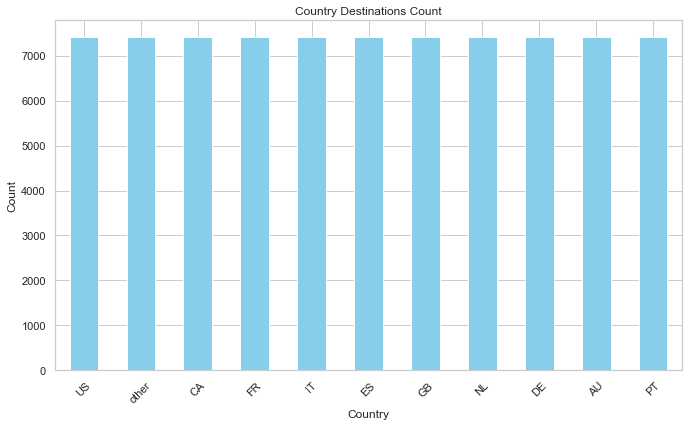

In [23]:
# Separate features and target
X = df_airbnb_cleaned.drop('country_destination', axis=1)
y = df_airbnb_cleaned['country_destination']

# Step 1: Undersample the majority class ('US')
df_us = df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == 'US']
df_other = df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] != 'US']

# Undersample "US" to match the count of the second most frequent class
df_us_under = resample(df_us, replace=False, n_samples=max(df_other['country_destination'].value_counts()), random_state=42)

# Combine undersampled "US" with the minority classes
df_balanced = pd.concat([df_us_under, df_other])

# Separate features and target variable
X_balanced = df_balanced.drop('country_destination', axis=1)
y_balanced = df_balanced['country_destination']

# Step 2: Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_balanced, y_balanced)

# Print value counts of the target variable after oversampling
print(pd.Series(y_resampled).value_counts())

countr_destinations_counts = pd.Series(y_resampled).value_counts()

# Create bar chart
plt.figure(figsize=(10, 6))
countr_destinations_counts.plot(kind='bar', color='skyblue')
plt.title('Country Destinations Count')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Analysis
Visually, the distribution is much more consistant across all the target value destinations, with each country containing 7557 data entries. Please reference the second graph in this notebook to compare with the previous distribution.

## Test-Train Split
Using the test-train split data, split the test data into Test/Train data sets for the models.  

In [24]:
# Perform train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Extract numerical and categorical columns again

categorical_features = X_train.select_dtypes(include=['object','category']).columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

## Feature Encoding
The categorical data needs to be encoded so the values can be represented in a matrix for model training and prediction. One-hot encoding was the chosen encoding method. After the categorical data has been encoded, it is combined with the numerical data to form the final data frames that will be used for training and predictions.

In [25]:
# Select only the categorical columns from the training and testing data
X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numeric_features]
X_test_categorical = X_test[categorical_features]
X_test_numerical = X_test[numeric_features]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical features in the training data
X_train_categorical_encoded = encoder.fit_transform(X_train_categorical)

# Transform the categorical features in the testing data
X_test_categorical_encoded = encoder.transform(X_test_categorical)

# Convert sparse matrices to DataFrames
X_train_categorical_df = pd.DataFrame(X_train_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(input_features=categorical_features))
X_test_categorical_df = pd.DataFrame(X_test_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(input_features=categorical_features))

X_train_numerical.reset_index(drop=True, inplace=True)
X_test_numerical.reset_index(drop=True, inplace=True)

# Concatenate DataFrames along axis=1 (horizontally) with the numerical features
X_train_encoded = pd.concat([X_train_categorical_df, X_train_numerical], axis=1)
X_test_encoded = pd.concat([X_test_categorical_df, X_test_numerical], axis=1)

# Modeling
Two different modeling techniques were used, Decision Trees and K-Means.

## Supervised Classifiers (Decision Trees) and Ensembles
Three decisions trees were used, then utilizing an ensemble method, they were combined to form the most accurate decision tree predictor.

### Random Forest
The following code uses the country_destination feature with the target_names defined to train the Random Forest model as well as create predictions. The overall classification_report is printed to screen.

In [26]:
rf=RandomForestClassifier()

rf.fit(X_train_encoded,y_train)
target_names = ['US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU']
y_pred_rf=rf.predict(X_test_encoded)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

          US       0.66      0.72      0.69      1484
       other       0.62      0.63      0.62      1552
          FR       0.61      0.66      0.63      1437
          CA       0.54      0.57      0.55      1496
          GB       0.41      0.38      0.39      1484
          ES       0.54      0.54      0.54      1483
          IT       0.51      0.52      0.51      1482
          PT       0.63      0.67      0.65      1488
          NL       0.76      0.82      0.79      1515
          DE       0.24      0.20      0.21      1471
          AU       0.25      0.21      0.23      1417

    accuracy                           0.54     16309
   macro avg       0.52      0.54      0.53     16309
weighted avg       0.53      0.54      0.53     16309



#### Analysis
The overall metrics of this model seem to indicate that it preformed relativley well on the data provided. The high f1-scores as well as overall accuracy indicate the the model is accurately predicting values. The precision and recall scores are also, overall, relatively high, indicating that false positives were correctly identified. The overall accuracy is .58, which is slightly better than chance, so more modeling and methods are needed to accurately report on this.

### Random Forest Metrics
The following code generates a graph that depicts the feature importance identified by the random forest model above.

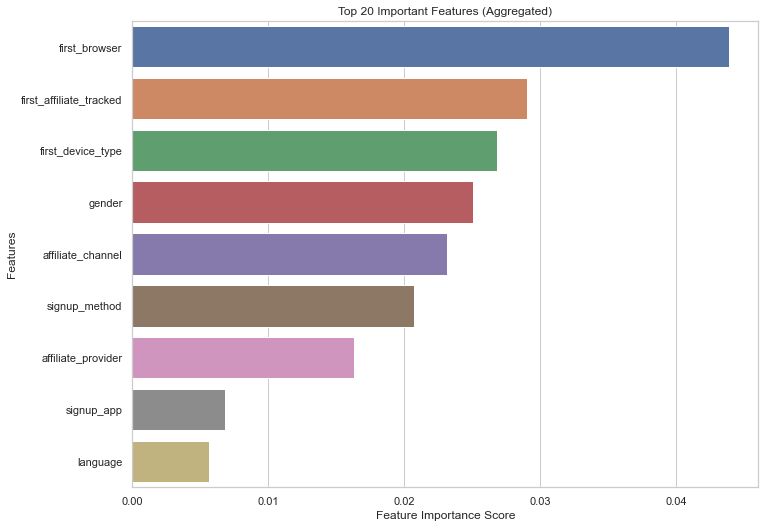

In [27]:
# Used chatGPT for this :

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

feature_names=list(X_train_encoded.columns.values.tolist())
feature_imp = pd.Series(rf.feature_importances_,index=feature_names).sort_values(ascending=False)

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()

#### Analysis
The first important takeaway is the scale for the feature importance score, the difference in values on the x-axis are small and relatively insignificant. This indicates that the model did have a difficult time identifying clear features that standout as predictive features. Despite this micro view, the ranking of the features can be helpful in identifying features to expand upon or investigate further. Many of these features are related to how the user made the booking (browser, signup_app, device_type, etc.) and not as many are focused on the specific user demographics (gender, age, language).

### XGBoost
The following code uses XGBoost to generate predictions on the same dataset. The nuances of XGBoost include the need for specific encoding and reshaping to fit the models needs. Those extra steps are made before training and using the model.

In [28]:
# Lots of ChatGPT help here. Apparently it's not easy to go from categoricals to one_hot_encoding for XGBoost directly for y (Target)
# Need to first convert to label encodings and then one hot

# Initialize LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Convert y_train and y_test to NumPy arrays
y_train_array = y_train.values
y_test_array = y_test.values

# Encode y_train with LabelEncoder
y_train_labels = label_encoder.fit_transform(y_train_array)

# Reshape y_train_labels to be 2D and apply OneHotEncoder
y_train_reshaped = y_train_labels.reshape(-1, 1)
y_train_encoded = one_hot_encoder.fit_transform(y_train_reshaped)

# Train the model
xgb = XGBClassifier()
xgb.fit(X_train_encoded, y_train_encoded)

# Predict using the model
y_pred_xgb_encoded = xgb.predict(X_test_encoded)

# Decode predictions to original label format using LabelEncoder
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded.argmax(axis=1))

# Print classification report
print(classification_report(y_test_array, y_pred_xgb, target_names=target_names))

              precision    recall  f1-score   support

          US       0.10      0.98      0.19      1484
       other       0.78      0.13      0.22      1552
          FR       0.84      0.13      0.23      1437
          CA       0.81      0.09      0.15      1496
          GB       0.58      0.02      0.04      1484
          ES       0.82      0.06      0.12      1483
          IT       0.71      0.06      0.12      1482
          PT       0.87      0.21      0.33      1488
          NL       0.87      0.54      0.67      1515
          DE       0.43      0.04      0.08      1471
          AU       0.43      0.04      0.07      1417

    accuracy                           0.21     16309
   macro avg       0.66      0.21      0.20     16309
weighted avg       0.66      0.21      0.20     16309



#### Accuracy
This model preformed, overall, noticeably worse than the random forest model. The f1-scores and accuracy scores were significantly lower for each of the target countries. The precision and recall seemed to have varied more than the random forest, with some values being high. This indicates that the model may provide some valuable insights as to avoiding false positives, or accurately identifying positives.

## XGBoost Metrics
The following code uses similar methods as the random forest metrics to generate a comparison on the top 10 predictive features after training this model.

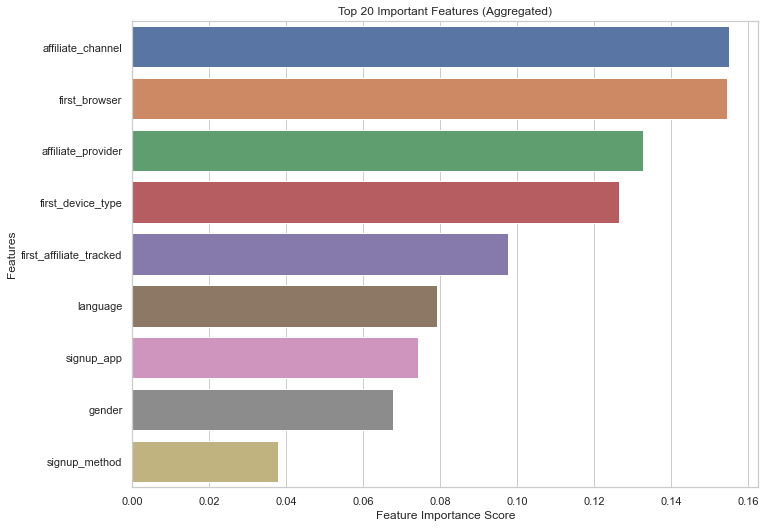

In [29]:
# Used chatGPT for this :

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

feature_names=list(X_train_encoded.columns.values.tolist())
feature_imp = pd.Series(xgb.feature_importances_,index=feature_names).sort_values(ascending=False)

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()



#### Analysis
The first important note is the larger scale for the feature importance score than Random Forest. This indicates a more distinctive feature differentiation, however, the scale is still relatively small from 0-1. This feature importance highlights the distinction between the signup related data and the demographic data even more. While Language and Gender were in the top 10 features, they were at the bottom, compared to signup related data.

### CatBoost
Since boosting seemed to have some positive effects indicating strong preformance, the use of CatBoost was chosen to help boost accuracy metrics. CatBoost is optimized for categorical data, but can work with both. Since this dataset contains both numerical and categorical data, this is a good model to use for comparison to see if the categorical features do happen to impact the data more than the numerical data, ie this model will preform better.

In [30]:
catboost = CatBoostClassifier()
catboost.fit(X_train_encoded, y_train)

y_pred_catboost = catboost.predict(X_test_encoded)

print(classification_report(y_test, y_pred_catboost))

Learning rate set to 0.097918
0:	learn: 2.3850210	total: 199ms	remaining: 3m 18s
1:	learn: 2.3733565	total: 256ms	remaining: 2m 7s
2:	learn: 2.3624805	total: 314ms	remaining: 1m 44s
3:	learn: 2.3550241	total: 373ms	remaining: 1m 32s
4:	learn: 2.3471735	total: 431ms	remaining: 1m 25s
5:	learn: 2.3421798	total: 487ms	remaining: 1m 20s
6:	learn: 2.3326533	total: 545ms	remaining: 1m 17s
7:	learn: 2.3263541	total: 607ms	remaining: 1m 15s
8:	learn: 2.3227296	total: 664ms	remaining: 1m 13s
9:	learn: 2.3181709	total: 718ms	remaining: 1m 11s
10:	learn: 2.3130777	total: 770ms	remaining: 1m 9s
11:	learn: 2.3084647	total: 827ms	remaining: 1m 8s
12:	learn: 2.3030719	total: 883ms	remaining: 1m 7s
13:	learn: 2.2952860	total: 940ms	remaining: 1m 6s
14:	learn: 2.2882646	total: 993ms	remaining: 1m 5s
15:	learn: 2.2833957	total: 1.09s	remaining: 1m 6s
16:	learn: 2.2780465	total: 1.18s	remaining: 1m 7s
17:	learn: 2.2717082	total: 1.24s	remaining: 1m 7s
18:	learn: 2.2653399	total: 1.29s	remaining: 1m 6s
19

#### Analysis
This model preformed between RandomForest and XGBoost. The accuracy score is not very high, but the f1-scores seemed to improve compared to the XGBoost model.

### CatBoost Metrics
Below is the same feature importance metrics graphing method as the other models.

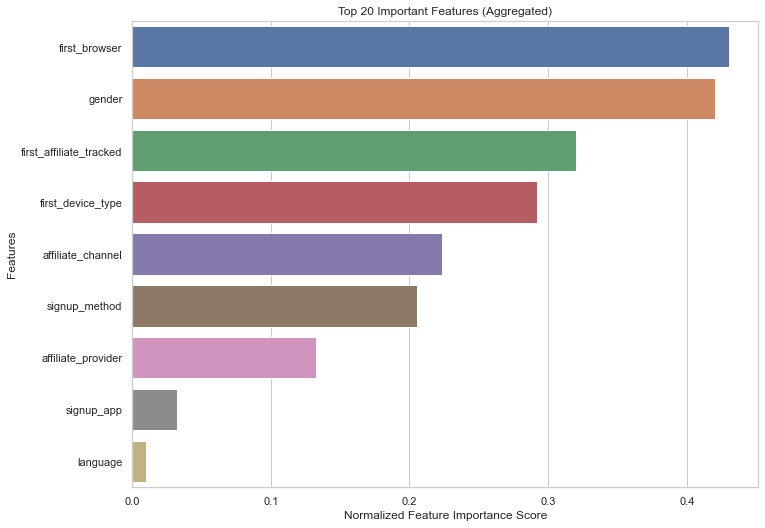

In [31]:
# Extract feature importances
feature_imp = pd.Series(catboost.get_feature_importance(), index=X_train_encoded.columns).sort_values(ascending=False)

# Normalize the feature importances to be between 0 and 1
normalized_feature_imp = feature_imp / feature_imp.max()

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = normalized_feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Normalized Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()


#### Analysis
Looking at the scale for feature importance, this model seemed to distinguish between features significantly better than the other two models. The scale increases by .1 each time compared to 0.01 compared to Random Forest. This higher distinction of features is a good indicator that the model is correctly identifying feature distinction, however combined with the lower accuracy score it is clear the data may not be as correlated with the target variable as hypothesized.

### Voting Ensemble
Utilizing Ensemble methods are a good tool in combining the strengths of several models to create a more comprehensive model that is as good as, if not better than the combined models. The three models discussed above are the models used in this ensemble method. The use of soft voting was chosen to try to enhance the features that had lower accuracy scores but seemed to distinguish between predictive features better. Soft voting also worked better with the shape of CatBoost, using hard voting caused some computational problems that were resolved with soft voting.

In [32]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train_array)

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xg', xgb), ('cb', catboost)], voting='soft')

# Fit the ensemble model using the encoded target labels
ensemble_model.fit(X_train_encoded, y_train_encoded)

# Make predictions
y_pred_encoded = ensemble_model.predict(X_test_encoded)

# Decode predictions to original label format using LabelEncoder
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test_array, y_pred, target_names=target_names))

Learning rate set to 0.097918
0:	learn: 2.3850210	total: 58.6ms	remaining: 58.5s
1:	learn: 2.3733565	total: 118ms	remaining: 59s
2:	learn: 2.3624805	total: 172ms	remaining: 57s
3:	learn: 2.3550241	total: 226ms	remaining: 56.3s
4:	learn: 2.3471735	total: 280ms	remaining: 55.8s
5:	learn: 2.3421798	total: 334ms	remaining: 55.3s
6:	learn: 2.3326533	total: 386ms	remaining: 54.8s
7:	learn: 2.3263541	total: 440ms	remaining: 54.6s
8:	learn: 2.3227296	total: 499ms	remaining: 54.9s
9:	learn: 2.3181709	total: 556ms	remaining: 55s
10:	learn: 2.3130777	total: 619ms	remaining: 55.7s
11:	learn: 2.3084647	total: 676ms	remaining: 55.6s
12:	learn: 2.3030719	total: 731ms	remaining: 55.5s
13:	learn: 2.2952860	total: 787ms	remaining: 55.4s
14:	learn: 2.2882646	total: 847ms	remaining: 55.6s
15:	learn: 2.2833957	total: 909ms	remaining: 55.9s
16:	learn: 2.2780465	total: 967ms	remaining: 55.9s
17:	learn: 2.2717082	total: 1.02s	remaining: 55.6s
18:	learn: 2.2653399	total: 1.07s	remaining: 55.5s
19:	learn: 2.260

#### Analysis
The accuracy and f1-scores look to be the highest accross all the other models. Precision and recall are also generally higher than the other models. Upon initial analysis it seems the ensemble model did preform the best of the models.

### Ensemble Feature Importance Metrics
This code is similar to the other feature importance metrics computations. The noticable difference is the average across all the features.

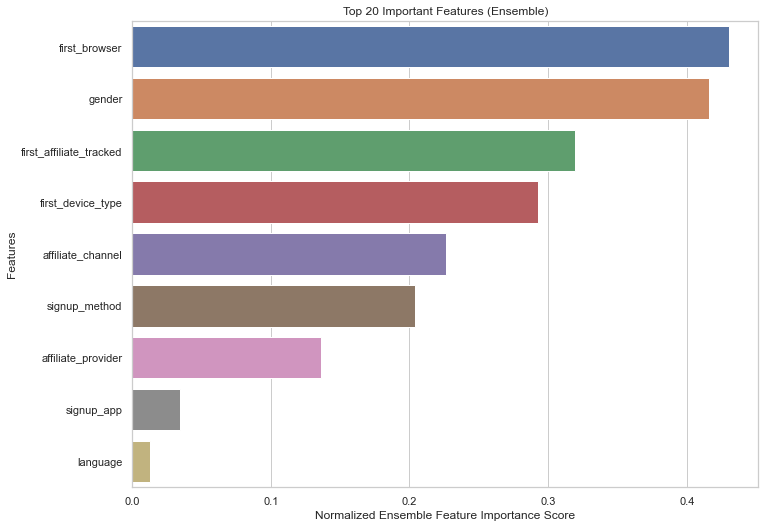

In [33]:

# Extract feature importances for each model in the ensemble
rf_feature_imp = pd.Series(rf.feature_importances_, index=X_train_encoded.columns)
xgb_feature_imp = pd.Series(xgb.feature_importances_, index=X_train_encoded.columns)
cb_feature_imp = pd.Series(catboost.get_feature_importance(), index=X_train_encoded.columns)

# Calculate the average feature importance across all models
ensemble_feature_imp = (rf_feature_imp + xgb_feature_imp + cb_feature_imp) / 3

# Normalize the feature importances to be between 0 and 1
normalized_ensemble_feature_imp = ensemble_feature_imp / ensemble_feature_imp.max()

# Initialize an empty dictionary to store aggregated feature importances
aggregated_ensemble_feature_importance = {}

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = normalized_ensemble_feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_ensemble_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_ensemble_feature_imp_series = pd.Series(aggregated_ensemble_feature_importance)

# Sort the aggregated feature importance Series
aggregated_ensemble_feature_imp_series_sorted = aggregated_ensemble_feature_imp_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_ensemble_feature_imp_series_sorted[:20], y=aggregated_ensemble_feature_imp_series_sorted.index[:20])
plt.xlabel('Normalized Ensemble Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Ensemble)")
plt.show()

#### Analysis
This feature importance graph is well scaled. The listed features are similar to those from the other models and align with the expected output of this technique.

# Supervised Model Evaluation
The following code generates a graph that compares the model accuracy across the four models above.

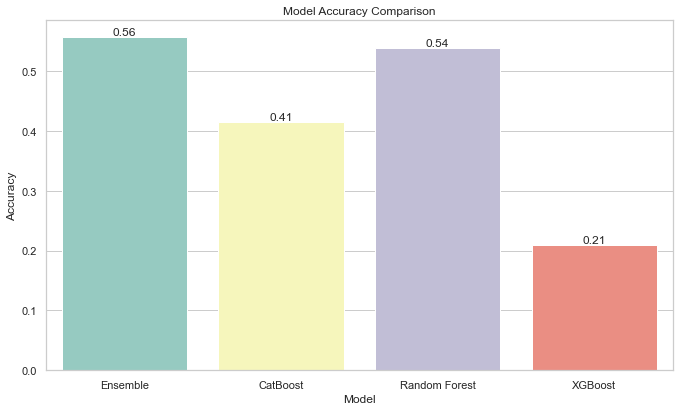

In [34]:
# List of model names
model_names = ['Ensemble', 'CatBoost', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_catboost), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)]

# Create a bar chart showing accuracy score comparisons
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette='Set3')

# Add accuracy scores above each bar
for i in range(len(model_names)):
  plt.text(i, accuracy_scores[i], f'{accuracy_scores[i]:.2f}', ha='center', va='bottom')

plt.title('Accuracy Score Comparison')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

#### Analysis
The bar graph above visualizes the analysis throughout each of these models. The ensemble model did preform the best of the four models, however random forest was not significantly different as far as accuracy metrics. The Boosting algorithms did not preform as well in terms of accuracy, but they did have slightly more distinguishable feature importance measures. Combining the three models (CatBoost, RandomForest and XGBoost) with the voting in the ensemble method did create the best overall output, however with a low accuracy score and f1-scores that were not consistant across the countries (denmark is very low), it is hard to claim that this model is a good predictor of destination country. The feature importance showed a divide between the features indicating the method a user took to signup vs demographics on the user. Further collecting data in this realm might indicate better performance. The distinction and handling of both categorical and numerical values also skewed some of the models. CatBoost, for instance, preforms better for categorical data, however in our data preprocessing it was aparent that the numerical data had stronger correlations than the categorical data. Attempting to bridge some of these data gaps would help increase model preformance and overall predictive accuracy.

# K-Means Clustering

In [114]:
df_kms_train = X_train.copy()

numeric_features = df_kms_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

df_kms_train[numeric_features] = scaler.fit_transform(df_kms_train[numeric_features])

categorical_features = df_kms_train.select_dtypes(include='object').columns

df_kms_encoded = pd.get_dummies(df_kms_train, columns=categorical_features, drop_first=True)
# display(df_kms_encoded.info())

In [36]:
def kmeans_execution(df, num_clusters):
    # Create models & store labels for different number of clusters
    model = KMeans(n_clusters = num_clusters, n_init='auto', random_state = 0) # Create KMeans object
    model.fit(df) # Apply to the data
    labels = model.labels_ # Capture K-Means labels
    distortion = model.inertia_ # Used for elbow method
    silhouette = silhouette_score(df, labels)
    centers = model.cluster_centers_
    return {
        'model' : model,
        'centers' : centers,
        'labels' : labels,
        'distortion' : distortion,
        'silhouette_score' : silhouette
    }

In [55]:
def analyze_cluster_sizes(kmeans_results, n_clusters):
    labels = kmeans_results[n_clusters]['labels']

    cluster_sizes = pd.Series(labels).value_counts().sort_index()

    total_points = len(labels)
    cluster_percentages = (cluster_sizes / total_points * 100).round(2)

    cluster_info = pd.DataFrame({
        'Count': cluster_sizes,
        'Percentage': cluster_percentages
    })

    print("Cluster Sizes:")
    print(cluster_info)

    plt.figure(figsize=(15, 6))
    # bar chart
    plt.subplot(1, 2, 1)
    cluster_sizes.plot(kind='bar')
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Data Points')
    # pie chart
    plt.subplot(1, 2, 2)
    plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%')
    plt.title('Cluster Size Distribution')
    plt.tight_layout()
    plt.show()

In [38]:
kms_cluster_results = {}
max_silhouette_score = -1
optimal_cluster = 0

num_clusters_range = range(2, 9)

for cluster in num_clusters_range:
    kms_cluster_results[cluster] = kmeans_execution(df_kms_encoded, cluster)
    print(f"Silhouette score for {cluster} clusters = {kms_cluster_results[cluster]['silhouette_score']}")
    if kms_cluster_results[cluster]['silhouette_score'] > max_silhouette_score:
        max_silhouette_score = kms_cluster_results[cluster]['silhouette_score']
        optimal_cluster = cluster

Silhouette score for 2 clusters = 0.16785928709043194
Silhouette score for 3 clusters = 0.20848024699726322
Silhouette score for 4 clusters = 0.14734407510482936
Silhouette score for 5 clusters = 0.16063947044040297
Silhouette score for 6 clusters = 0.17310267474460186
Silhouette score for 7 clusters = 0.14499132465186634
Silhouette score for 8 clusters = 0.14558615737542202


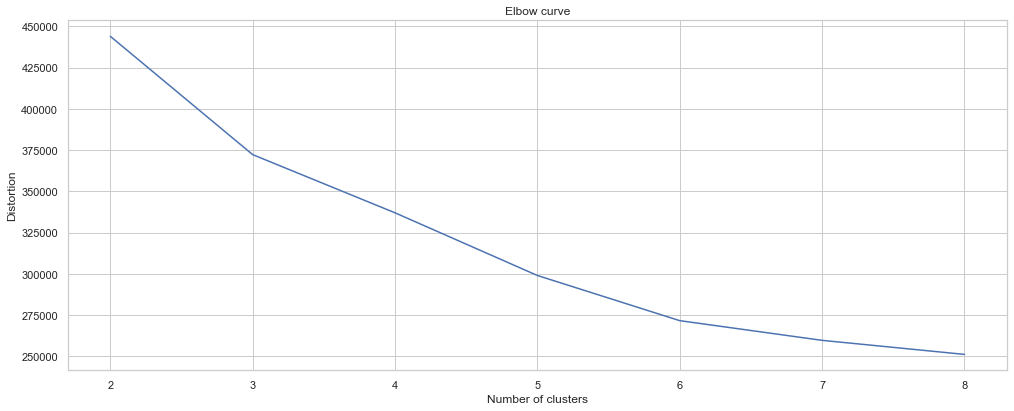

In [56]:
inertia = [kms_cluster_results[cluster]['distortion'] for cluster in num_clusters_range]

fig = plt.figure(figsize=(15, 6))
plt.plot(num_clusters_range, inertia)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [57]:
# ideal_cluster_size = optimal_cluster
ideal_cluster_size = 6

Cluster Sizes:
   Count  Percentage
0  11272       17.28
1   2862        4.39
2  23060       35.35
3   4987        7.64
4   8663       13.28
5  14390       22.06


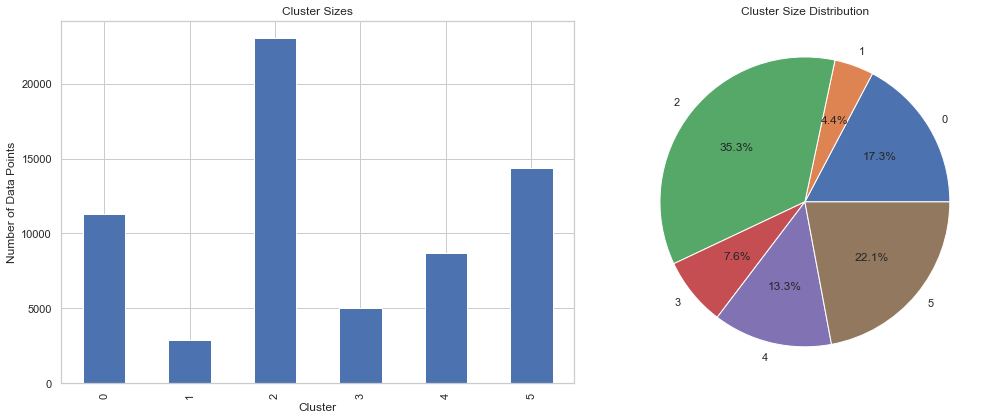

In [58]:
analyze_cluster_sizes(kms_cluster_results, ideal_cluster_size)

In [59]:
# evaluation

# Add the optimal cluster labels to the original dataframe X_train
kms_eval = X_train.copy()
kms_eval['cluster_label'] = kms_cluster_results[optimal_cluster]['labels']
kms_eval['country_dest'] = y_resampled
kms_eval['cluster_label'] = kms_cluster_results[ideal_cluster_size]['labels']

In [60]:
def group_by_cluster(df, col_val):
    exclude_columns = ['country_dest', 'clusterlabel']
    cont_cols = [col for col in df.columns if col not in exclude_columns]
    # Get summary stats grouped by cluster
    df_group = df.groupby(col_val)[cont_cols].agg(['mean', 'median', 'std']).reset_index()
    # See distribution of target variable grouped by cluster
    value_counts = df.groupby(col_val)['country_dest'].agg(lambda x:x.value_counts().to_dict())
    return df_group, value_counts

In [61]:
pd.set_option('display.max_colwidth', None)
summary_stats, target_groups = group_by_cluster(kms_eval, kms_cluster_results[ideal_cluster_size]['labels'])

In [115]:
target_groups

0         {'NL': 1229, 'DE': 1124, 'other': 1076, 'IT': 1055, 'PT': 1031, 'GB': 1012, 'FR': 982, 'ES': 975, 'US': 960, 'CA': 928, 'AU': 900}
1               {'other': 429, 'US': 386, 'IT': 356, 'ES': 306, 'GB': 303, 'FR': 268, 'CA': 213, 'NL': 202, 'PT': 144, 'AU': 136, 'DE': 119}
2    {'AU': 2456, 'PT': 2396, 'NL': 2202, 'CA': 2137, 'US': 2057, 'DE': 2055, 'ES': 2032, 'other': 2029, 'IT': 1950, 'FR': 1910, 'GB': 1836}
3               {'US': 634, 'other': 601, 'AU': 513, 'CA': 483, 'ES': 426, 'NL': 426, 'IT': 418, 'GB': 417, 'DE': 394, 'FR': 371, 'PT': 304}
4              {'GB': 1006, 'FR': 910, 'IT': 874, 'DE': 821, 'AU': 790, 'CA': 749, 'other': 738, 'PT': 708, 'NL': 706, 'ES': 696, 'US': 665}
5    {'FR': 1488, 'ES': 1482, 'DE': 1463, 'GB': 1356, 'CA': 1351, 'PT': 1315, 'IT': 1278, 'US': 1240, 'NL': 1160, 'AU': 1134, 'other': 1123}
Name: country_dest, dtype: object

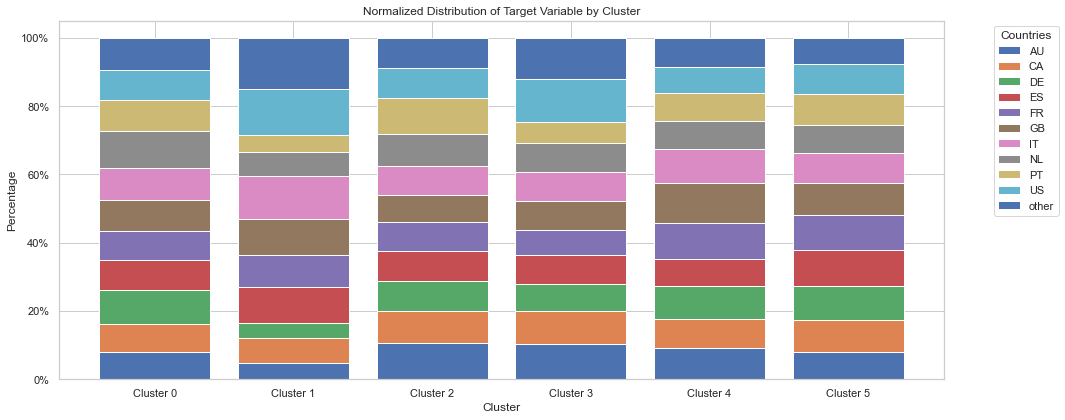

In [62]:
countries = sorted(set(country for group in target_groups for country in group))

data = []
for country in countries:
    data.append([group.get(country, 0) for group in target_groups])

data_array = np.array(data)
data_normalized = data_array / data_array.sum(axis=0) * 100

fig, ax = plt.subplots(figsize=(15, 6))

bottom = np.zeros(len(target_groups))
for i, d in enumerate(data_normalized):
    ax.bar(range(len(target_groups)), d, bottom=bottom, label=countries[i])
    bottom += d

ax.set_title('Normalized Distribution of Target Variable by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage')
ax.set_xticks(range(len(target_groups)))
ax.set_xticklabels([f'Cluster {i}' for i in target_groups.index])
ax.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.tight_layout()
plt.show()

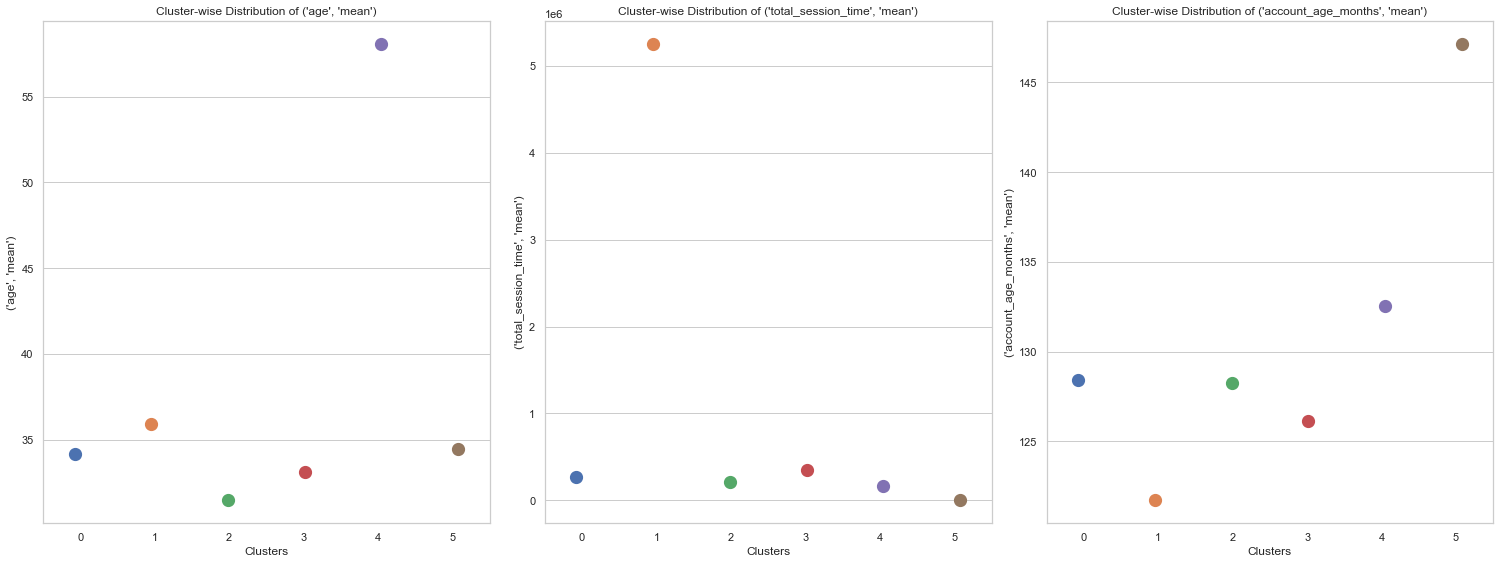

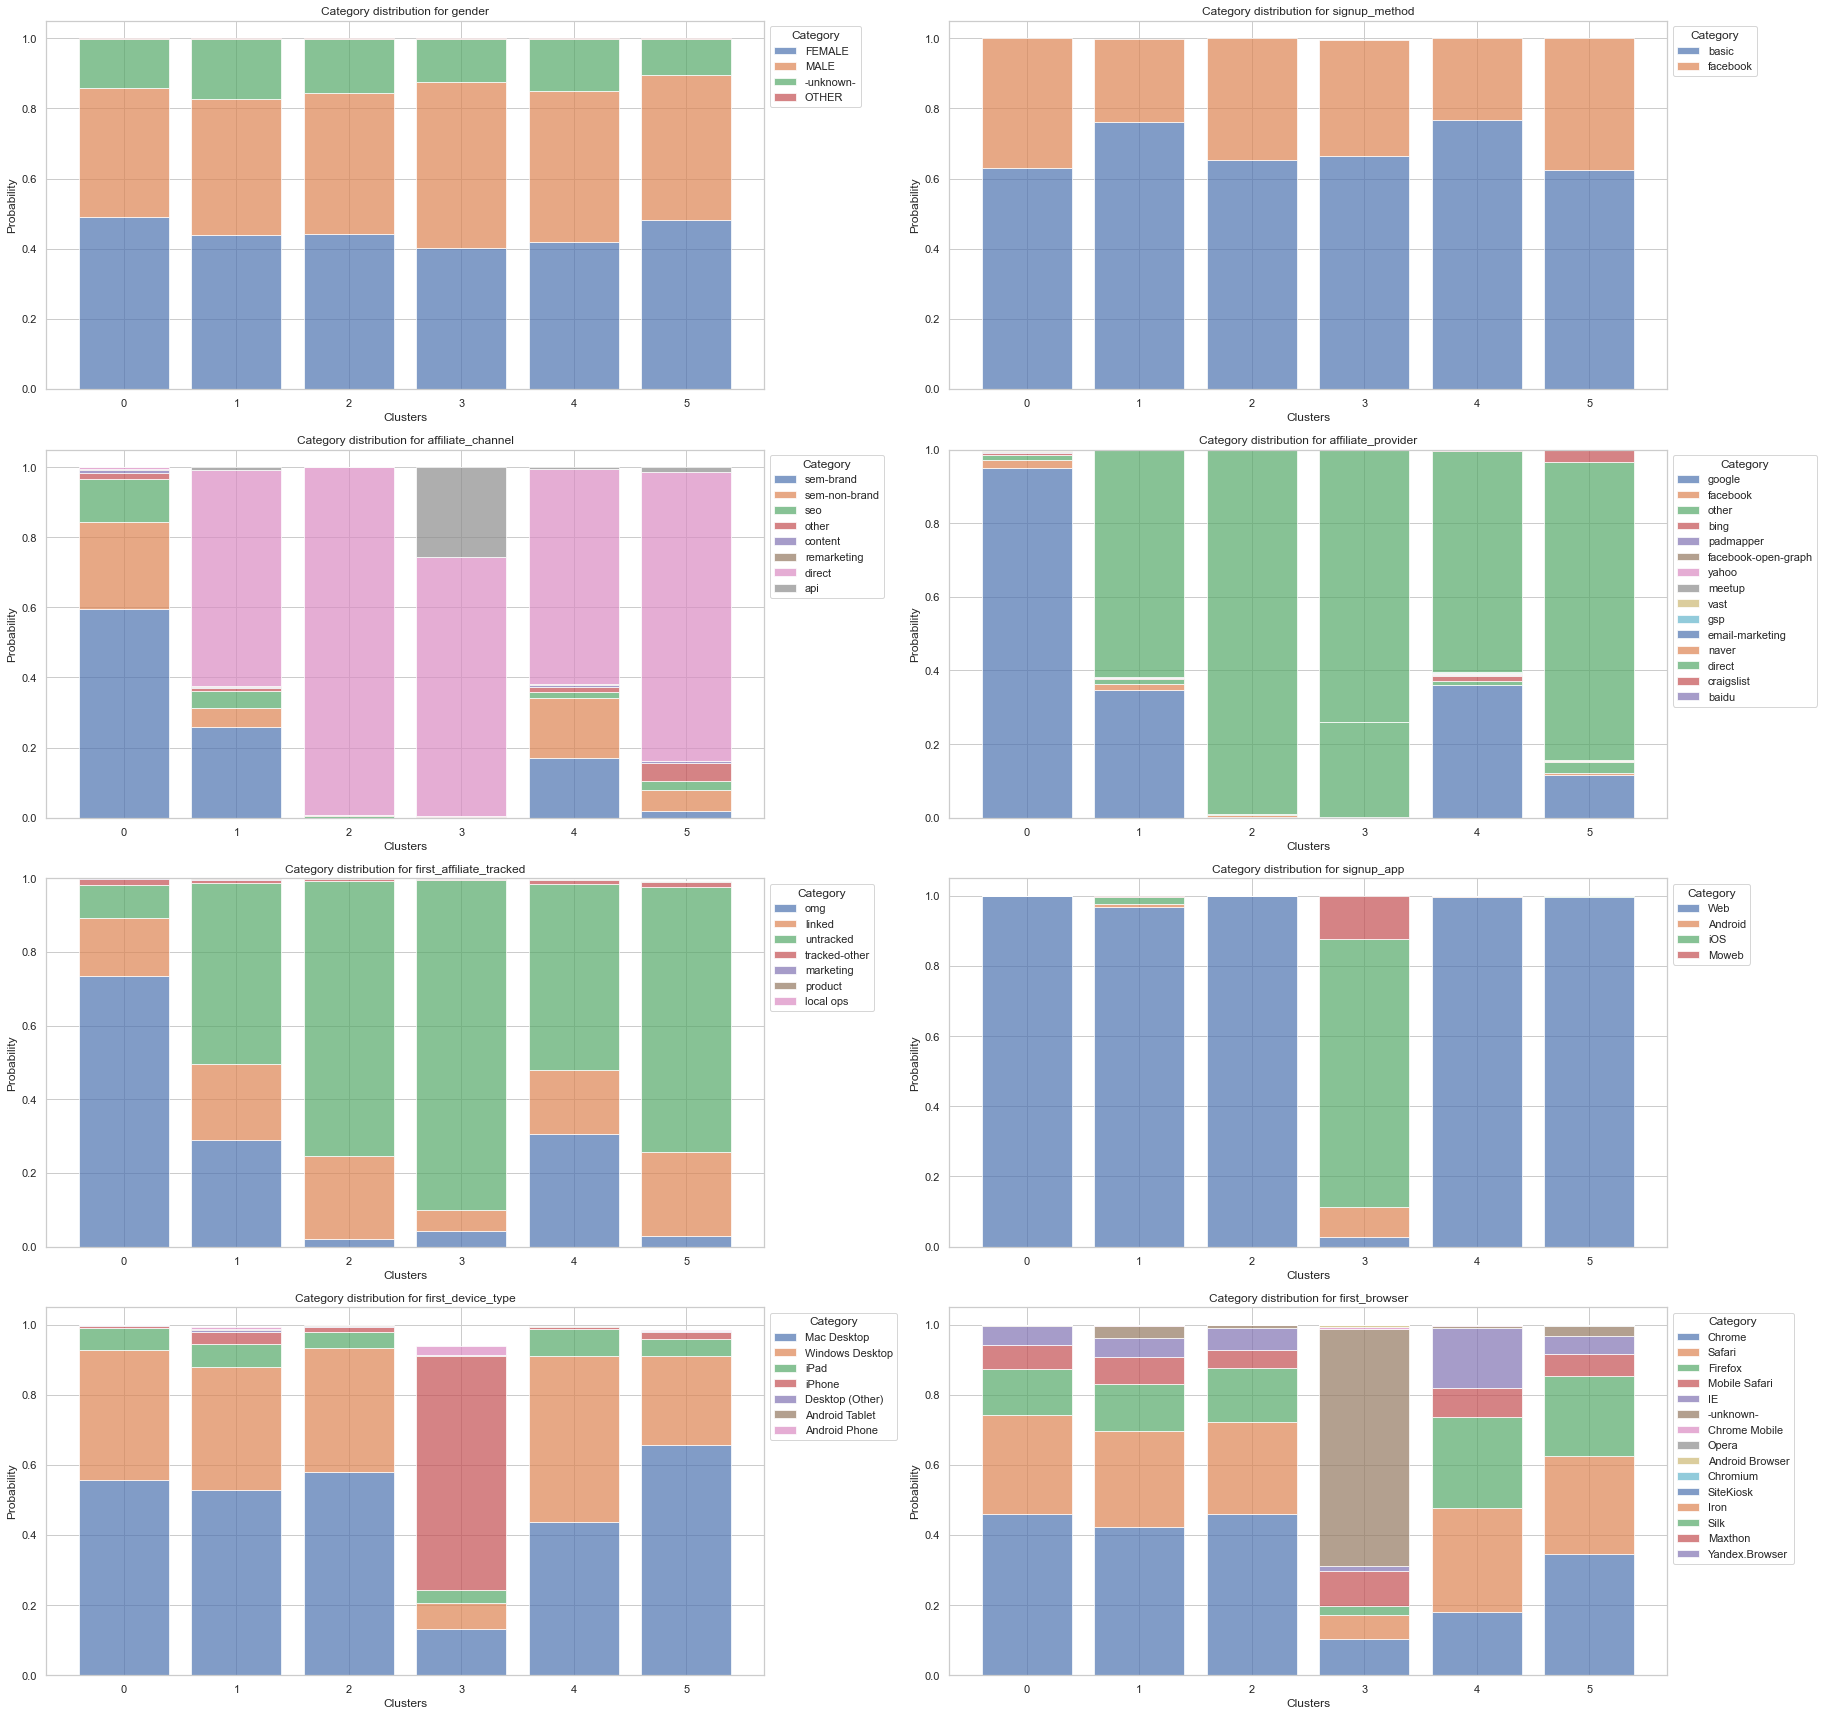

In [113]:
# Add the optimal cluster labels to the original dataframe X_train
X_train_with_labels = X_train.copy()
X_train_with_labels['cluster_labels'] = kms_cluster_results[ideal_cluster_size]['labels']

def group_by_cluster(df, col_val, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []
    
    cont_cols = [col for col in df.columns if col not in exclude_columns and np.issubdtype(df[col].dtype, np.number)]
    cat_cols = [col for col in df.columns if col not in exclude_columns and not np.issubdtype(df[col].dtype, np.number)]
    
    # Get summary stats grouped by cluster for continuous variables
    cont_summary = df.groupby(col_val)[cont_cols].agg(['mean']).reset_index()
    
    # Get value counts for categorical variables grouped by cluster
    cat_summary = df.groupby(col_val)[cat_cols].agg(lambda x: x.value_counts().to_dict()).reset_index()
    
    return cont_summary, cat_summary

exclude_columns = ['cluster_labels', 'language', 'signup_flow']  # Add more columns to exclude if necessary
summary_stats, cat_summary = group_by_cluster(X_train_with_labels, 'cluster_labels', exclude_columns=exclude_columns)

def visualize_continuous_summary(summary_stats):
    cols = summary_stats.columns[1:]
    num_cols = len(cols)
    
    # Create a figure with a single row and multiple columns
    fig, axes = plt.subplots(1, num_cols, figsize=(7*num_cols, 8))
    
    for i, col in enumerate(cols):
        sns.pointplot(data=summary_stats, x='cluster_labels', y=col, hue='cluster_labels', dodge=True, join=False, ax=axes[i], markers='o', scale=1.5)
        axes[i].set_xlabel('Clusters')
        axes[i].set_ylabel(col)
        axes[i].set_title(f'Cluster-wise Distribution of {col}')
        axes[i].legend_.remove()
        # axes[i].grid(True, axis='x')
    
    plt.tight_layout()
    plt.show()
        
# Function to visualize categorical variable summaries with stacked bar chart
def visualize_categorical_summary(cat_summary):
    cols = cat_summary.columns[1:]  # Exclude the cluster_labels column
    num_cols = len(cols)
    num_rows = (num_cols + 1) // 2  # Calculate the number of rows needed (2 graphs per row)

    # Create subplots with two graphs per row
    fig, axes = plt.subplots(num_rows, 2, figsize=(30, 6 * num_rows))  # Adjust the figsize as needed
    axes = axes.flatten()  # Flatten the array of axes for easier iteration

    for i, col in enumerate(cols):
        clusters = cat_summary['cluster_labels'].unique()
        bottom_values = np.zeros(len(clusters))
        for category in cat_summary[col][0].keys():
            cluster_probs = []
            for cluster, data in zip(cat_summary['cluster_labels'], cat_summary[col]):
                count = data.get(category, 0)
                total_count = sum(data.values())
                prob = count / total_count if total_count != 0 else 0
                cluster_probs.append(prob)
            axes[i].bar(clusters, cluster_probs, label=category, alpha=0.7, bottom=bottom_values)
            bottom_values += cluster_probs
        
        axes[i].set_title(f'Category distribution for {col}')
        axes[i].set_xlabel('Clusters')
        axes[i].set_ylabel('Probability')
        axes[i].set_xticks(clusters)
        axes[i].legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Visualize the summaries
visualize_continuous_summary(summary_stats)
visualize_categorical_summary(cat_summary)

### KMeans Interpretation

# Discussion and Conclusions